## Import Libraries

In [ ]:
# If you are running this code on Google Colab, run this:

!git clone https://github.com/Silvano315/Speech-Emotion-Recognition-model-and-gui.git

%cd /content/Speech-Emotion-Recognition-model-and-gui/notebooks
%pwd

In [ ]:
# WARNING !!!!

# REMEMBER TO IMPORT IN ~/.kaggle/kaggle.json with your Kaggle username and API token

%mkdir ~/.kaggle

# Open this folder in root/ 
# Upload your kaggle.json

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from ast import literal_eval
from IPython.display import Audio

from src.eda_fx import download_kaggle_dataset, load_data, plot_emotion_distribution, waveplot, spectogram, mel_spectrogram,\
                        mfcc_plot, zcr_plot, autocorrelation_plot, tonnetz_plot, rms_plot
from src.prepro import extract_features, preprocessing_df
from src.constants import DATA_DIR

## Download and Load dataset

In [2]:
# Download dataset to /data/raw

download_kaggle_dataset("uwrfkaggler/ravdess-emotional-speech-audio")

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
Dataset 'uwrfkaggler/ravdess-emotional-speech-audio' downloaded and extracted to '/Users/silvanoquarto/Desktop/PROJECTS/Speech-Emotion-Recognition-model-and-gui/data/raw/'.


In [2]:
# Load dataset

df = load_data(DATA_DIR)
df.head()

,path,emotion
0,../data/raw/Actor_16/03-01-05-01-02-01-16.wav,angry
1,../data/raw/Actor_16/03-01-06-01-02-02-16.wav,fearful
2,../data/raw/Actor_16/03-01-06-02-01-02-16.wav,fearful
3,../data/raw/Actor_16/03-01-05-02-01-01-16.wav,angry
4,../data/raw/Actor_16/03-01-07-01-01-01-16.wav,disgust


## Exploratory Data Analysis

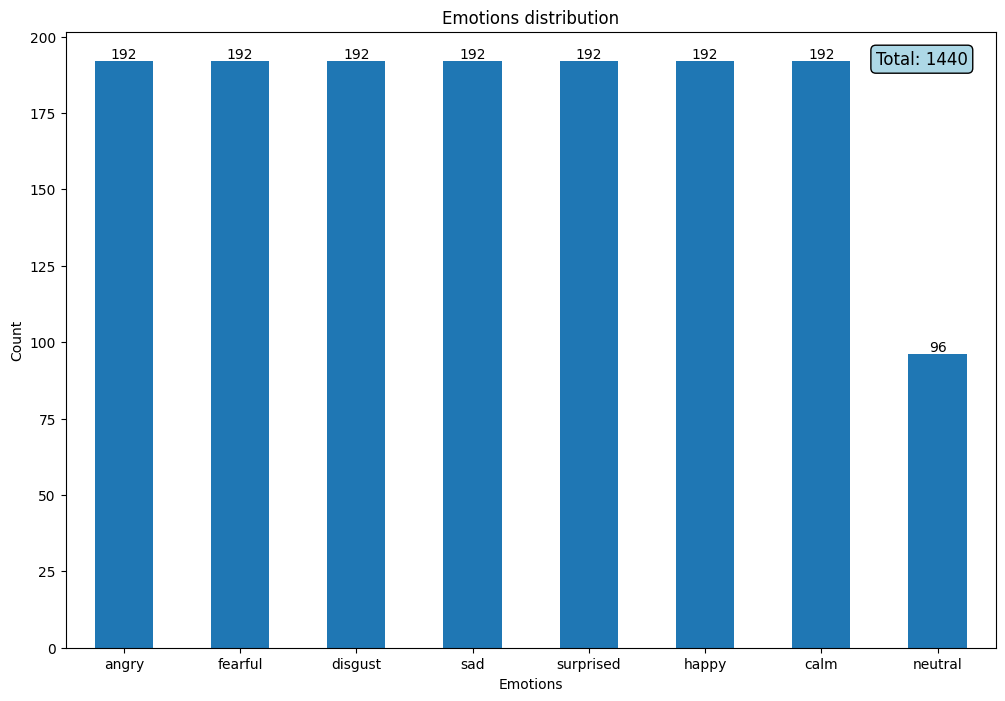

In [22]:
# Emotions distribution analysis

fig = plot_emotion_distribution(df)
fig.show()

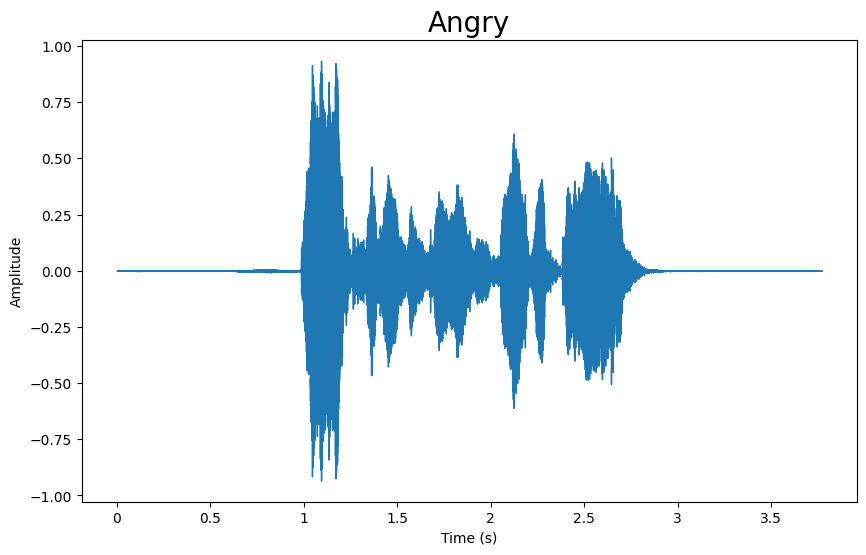

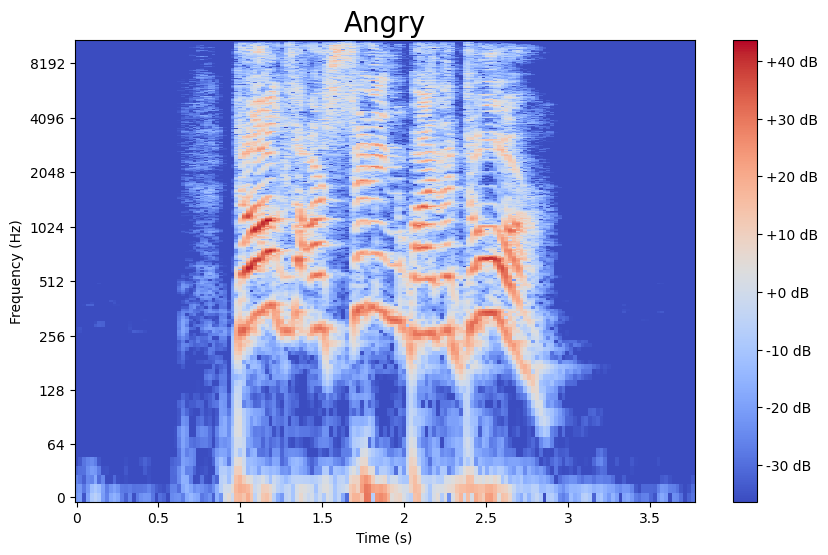

In [71]:
# Show waveplot, spectrogram and audio file from a random audio path

audio = np.random.randint(0,df.shape[0])
data, sampling_rate = librosa.load(df['path'][audio])
waveplot(data, sampling_rate, df['emotion'][0], play_audio=False)
spectogram(data, sampling_rate, emotion=df['emotion'][audio])
Audio(data=data, rate=sampling_rate)

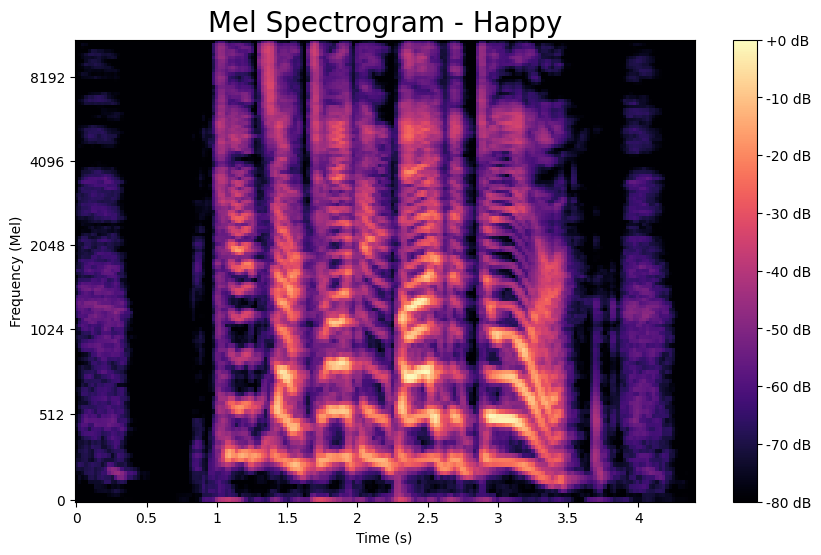

In [54]:
# Mel Spectrogram

mel_spectrogram(data, sampling_rate, df['emotion'][audio])

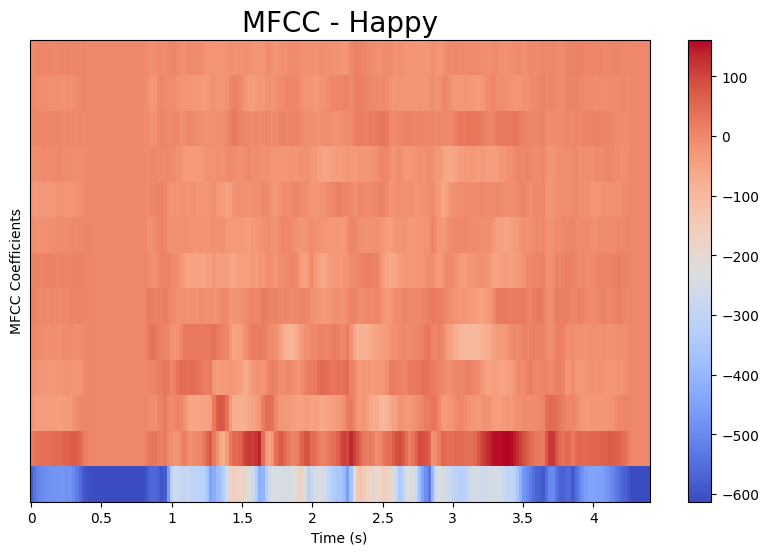

In [58]:
#MFCC plot

mfcc_plot(data, sampling_rate, df['emotion'][audio])

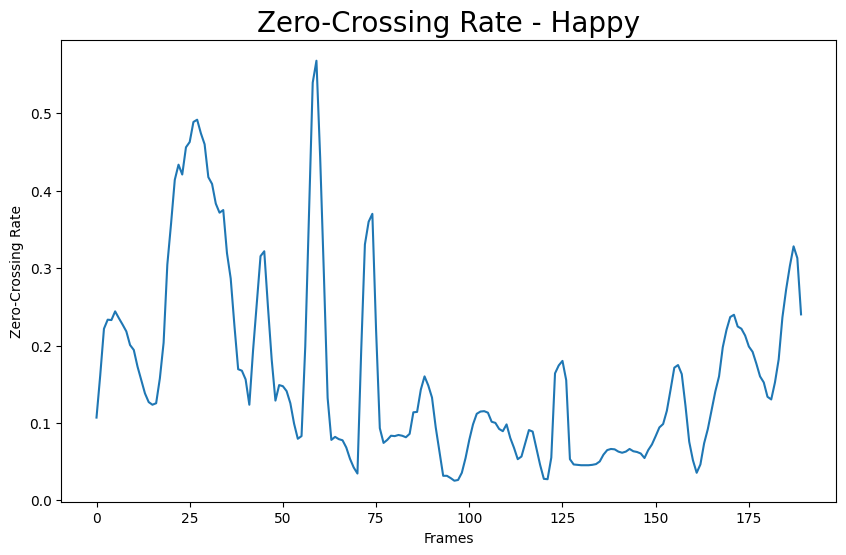

In [59]:
# Zero-Crossing Rate plot

zcr_plot(data, sampling_rate, df['emotion'][audio])

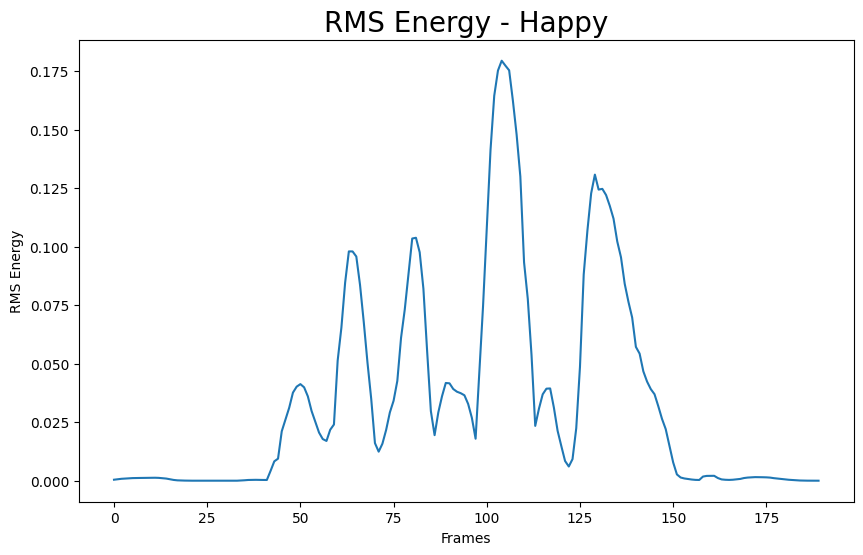

In [60]:
# RMS Energy plot

rms_plot(data, sampling_rate, df['emotion'][audio])

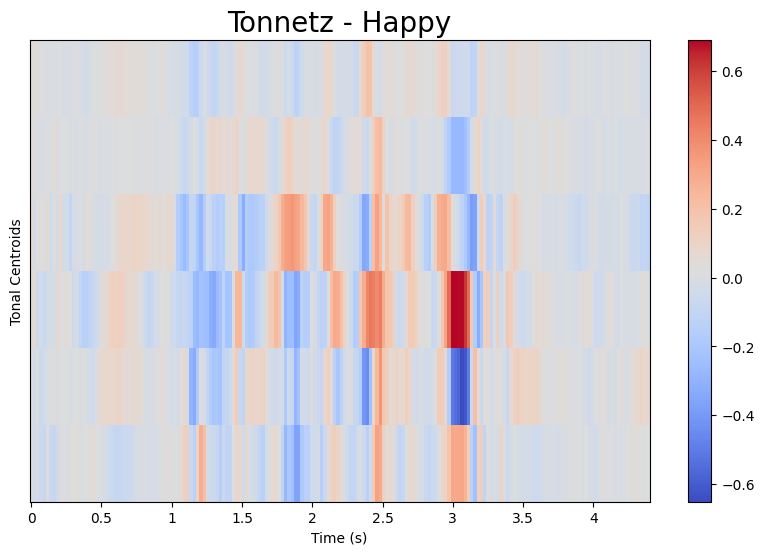

In [61]:
# Tonnetz plot

tonnetz_plot(data, sampling_rate, df['emotion'][audio])

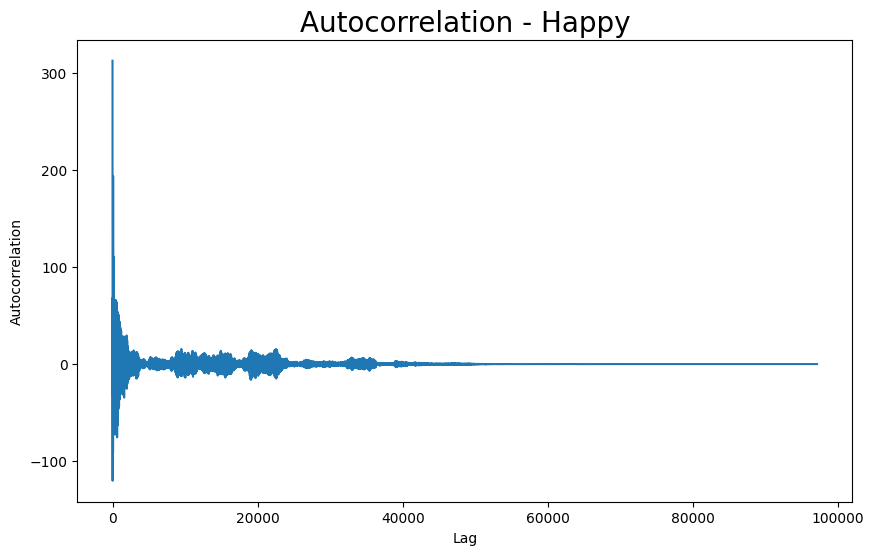

In [62]:
# Autocorrelation plot

autocorrelation_plot(data, sampling_rate, df['emotion'][audio])

## Feature Extraction and Preprocessing

In [3]:
# Extract MFCC features

df['features'] = df['path'].apply(lambda x : extract_features(x))

df.head()

,path,emotion,features
0,../data/raw/Actor_16/03-01-05-01-02-01-16.wav,angry,"[-488.45956, 42.61845, -6.084372, 3.0528846, -..."
1,../data/raw/Actor_16/03-01-06-01-02-02-16.wav,fearful,"[-523.67236, 42.90096, -6.9847674, 4.9217396, ..."
2,../data/raw/Actor_16/03-01-06-02-01-02-16.wav,fearful,"[-357.65732, 23.364548, -32.414146, 0.31153047..."
3,../data/raw/Actor_16/03-01-05-02-01-01-16.wav,angry,"[-390.4137, 43.01364, -12.396153, 5.3028054, -..."
4,../data/raw/Actor_16/03-01-07-01-01-01-16.wav,disgust,"[-586.23083, 57.13837, -0.46271926, 8.734296, ..."


In [5]:
# Savinng preprocessed df

saving_path = os.path.join(os.path.dirname(os.getcwd()), "data/preprocessed/")
if not os.path.exists(saving_path):
    os.makedirs(saving_path)

df.to_csv(os.path.join(saving_path, "mfcc_features_df.csv"), index=False)

In [3]:
# Load preprocessed df to perform One-Hot Encoding

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(literal_eval(array_string))

prepro_df_path = os.path.join(os.path.dirname(os.getcwd()), "data/preprocessed/mfcc_features_df.csv")

df = pd.read_csv(prepro_df_path, converters={'features' : from_np_array})

X, y = preprocessing_df(df)

X.shape, y.shape

((1440, 40), (1440, 8))

## Build LSTM Model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Layer, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from tensorflow.keras.backend import clear_session

In [7]:
# model with only LSTM

clear_session()

model = Sequential([
    Input(shape=(40,1)),
    #LSTM(128, return_sequences=True, input_shape=(40, 1)),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=L2(10e-3)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=L2(10e-3)),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,240 (481.41 KB)

 Trainable params: 122,856 (479.91 KB)

 Non-trainable params: 384 (1.50 KB)

In [2]:
def train_model_with_callbacks(model, X_train, y_train, X_val, y_val):

    early_stopping = EarlyStopping(
        monitor = 'val_loss', patience=10, restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        'best_model.keras', save_best_only = True,
        monitor = 'val_loss', mode = 'min'
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.5, patience = 5, min_lr=10e-6
    )

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, model_checkpoint, lr_scheduler]
    )

    return history

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)


history = train_model_with_callbacks(model, X_train, y_train, X_val, y_val)

In [12]:
# Model with CNN and LSTM

# This architecture combines convolutions (CNN) to capture local patterns in the MFCC features 
    # with an LSTM layer to manage the temporal sequencing of audio.

def build_cnn_lstm_model(input_shape):

    clear_session()

    model = Sequential()

    model.add(Input(shape=input_shape))

    model.add(Conv1D(
        filters = 64, kernel_size = 3, activation = 'relu'
    ))
    model.add(MaxPooling1D(
        pool_size = 2
    ))

    model.add(Conv1D(
        filters = 128, kernel_size = 3, activation = 'relu'
    ))
    model.add(MaxPooling1D(
        pool_size = 2
    ))

    model.add(LSTM(
        64, return_sequences = False
    ))

    model.add(Dense(
        units = 64, activation = 'relu'
    ))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(
        8, activation = 'softmax'
    ))

    return model

model = build_cnn_lstm_model(input_shape=(40, 1))

In [9]:
# LSTM with Attention Mechanism

# In this model, we use a simple implementation of the attention mechanism to improve the model’s focus on important time sequences.

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name = 'attention_weight', shape = (input_shape[-1], 1),
            initializer = 'random_normal', trainable = True
        )
        self.b = self.add_weight(
            name = 'attention_bias', shape = (input_shape[1], 1),
            initializer = 'random_normal', trainable = True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = inputs * attention_weights
        return tf.reduce_sum(context_vector, axis=1)
    
def build_lstm_attention_model(input_shape):
    model = Sequential()

    model.add(Input(shape=input_shape))

    model.add(LSTM(
        128, return_sequences = True
    ))

    model.add(AttentionLayer())

    model.add(Dense(
        64, activation = 'relu'
    ))
    model.add(Dropout(0.3))

    model.add(Dense(
        32, activation = 'relu'
    ))
    model.add(Dropout(0.3))

    model.add(Dense(8, activation='softmax'))

    return model

model = build_lstm_attention_model(input_shape=(40, 1))